In [1]:
from build_nba_bdd import export_all_seasons, export_all_teams_seasons, export_all_salaries, scrape_mvp_data, merge_data

In [ ]:
export_all_seasons()

In [ ]:
export_all_teams_seasons() # 5min environ

In [ ]:
export_all_salaries()

In [ ]:
scrape_mvp_data()

In [ ]:
merge_data() # Pour créer le data set sur lequel appliquer nos modèles (que pour Regular Season pour l'instant)

# Modèle de prédiction des salaires
Entraînement d'un modèle Random Forest pour prédire les salaires ajustés à l'inflation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Charger la base de données fusionnée
df = pd.read_csv('./data/merged_data.csv')

print(f"Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")
print(f"\nAperçu des colonnes:")
print(df.columns.tolist())

Dataset chargé: 10283 lignes, 78 colonnes

Aperçu des colonnes:
['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK', 'TEAM_COUNT', 'Rank', 'Position', 'Team', 'Salary', 'Season', 'TEAM_W_PCT', 'Year', 'adjusted_salary', 'next_adjusted_salary', 'Changed_team', 'YOE']


In [3]:
# Afficher les infos du dataframe

# Créer des tranches de salaire personnalisées
salary_brackets = [0, 300000, 1000000, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, 40000000, 45000000, 50000000, float('inf')]
salary_bracket_labels = ['<300K', '300K-1M', '1M-5M', '5M-10M', '10M-15M', '15M-20M', '20M-25M', '25M-30M', '30M-35M', '35M-40M', '40M-45M', '45M-50M', '>50M']

# Catégoriser les salaires ajustés
df['salary_bracket'] = pd.cut(df['adjusted_salary'], bins=salary_brackets, labels=salary_bracket_labels, include_lowest=True)

# Compter le nombre de personnes par tranche
salary_distribution = df['salary_bracket'].value_counts().sort_index()

print("\nNombre de personnes par tranche de salaire:")
print("="*50)
for bracket, count in salary_distribution.items():
    print(f"{bracket:>10}: {count:>5} personnes ({count/len(df)*100:>5.1f}%)")
print("="*50)
print(f"{'Total':>10}: {len(df):>5} personnes")

# Supprimer la colonne salary_bracket du dataframe original
df = df.drop(columns=['salary_bracket'])



Nombre de personnes par tranche de salaire:
     <300K:   272 personnes (  2.6%)
   300K-1M:   704 personnes (  6.8%)
     1M-5M:  4638 personnes ( 45.1%)
    5M-10M:  2003 personnes ( 19.5%)
   10M-15M:   982 personnes (  9.5%)
   15M-20M:   615 personnes (  6.0%)
   20M-25M:   451 personnes (  4.4%)
   25M-30M:   228 personnes (  2.2%)
   30M-35M:   158 personnes (  1.5%)
   35M-40M:   107 personnes (  1.0%)
   40M-45M:    60 personnes (  0.6%)
   45M-50M:    36 personnes (  0.4%)
      >50M:    29 personnes (  0.3%)
     Total: 10283 personnes


In [4]:
# Supprimer les lignes où Salary < 300000 (salaire minimum de la NBA en 2000)
print(f"Dataset avant filtrage: {len(df)} lignes")
df = df[df['Salary'] >= 300000]
df = df[df['next_adjusted_salary'] >= 600000]
print(f"Dataset après filtrage (salaire >= 300K): {len(df)} lignes")

# Catégoriser la colonne Position avant de la supprimer
if 'Position' in df.columns:
    print(f"\n Positions uniques trouvées:")
    print(df['Position'].value_counts())
    
    # Créer un mapping des positions vers des catégories numériques
    position_mapping = {
        'PG': 1,   # Point Guard
        'SG': 2,   # Shooting Guard
        'SF': 3,   # Small Forward
        'PF': 4,   # Power Forward
        'C': 5,    # Center
        'G': 6,    # Guard (générique)
        'F': 7,    # Forward (générique)
        'GF': 8,  # Guard-Forward
        '': 9     # Position inconnue
    }
    
    # Appliquer le mapping aux positions des joueurs
    df['position_category'] = df['Position'].map(position_mapping).fillna(0).astype(int)
    print(f"\n Colonne 'position_category' créée:")
    print("\n Colonne 'Position' non trouvée dans le dataset")

# Supprimer les colonnes inutiles pour la prédiction
columns_to_drop = ['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ABBREVIATION', 'Team', 'Salary', 'Season', 'Position', 'Rank']

# Vérifier quelles colonnes existent réellement
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
print(f"\n Colonnes à supprimer: {existing_columns_to_drop}")

df_clean = df.drop(columns=existing_columns_to_drop)

print(f"\n Dataset après nettoyage: {len(df_clean)} lignes, {len(df_clean.columns)} colonnes")
print(f"Colonnes restantes: {df_clean.columns.tolist()}")

Dataset avant filtrage: 10283 lignes
Dataset après filtrage (salaire >= 300K): 7902 lignes

 Positions uniques trouvées:
Position
C     1431
PF    1312
SG    1190
SF    1158
PG    1146
F      848
G      810
Name: count, dtype: int64

 Colonne 'position_category' créée:

 Colonne 'Position' non trouvée dans le dataset

 Colonnes à supprimer: ['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ABBREVIATION', 'Team', 'Salary', 'Season', 'Position', 'Rank']

 Dataset après nettoyage: 7902 lignes, 70 colonnes
Colonnes restantes: ['TEAM_ID', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 

In [5]:
# Créer une colonne catégorielle pour les saisons à partir de 'Year'
# Extraire l'année de début (ex: '1999-00' -> 1999)
df_clean['season_start_year'] = df_clean['Year'].str.split('-').str[0].astype(int)

# Créer une colonne catégorielle (1 pour 1999-00, 2 pour 2000-01, etc.)
min_year = df_clean['season_start_year'].min()
df_clean['season_category'] = df_clean['season_start_year'] - min_year + 1

print(f"\n Catégories de saisons créées:")
print(f"   Année minimale: {min_year} (catégorie 1)")
print(f"   Année maximale: {df_clean['season_start_year'].max()} (catégorie {df_clean['season_category'].max()})")


 Catégories de saisons créées:
   Année minimale: 1999 (catégorie 1)
   Année maximale: 2023 (catégorie 25)


In [6]:
# Supprimer les colonnes temporaires et Year
df_clean = df_clean.drop(columns=['Year', 'season_start_year'])

# Gérer les valeurs manquantes
print(f"\n Valeurs manquantes par colonne:")
missing_values = df_clean.isnull().sum()
print(missing_values[missing_values > 0])

# Supprimer les lignes où next_adjusted_salary est vide
df_clean = df_clean.dropna(subset=['next_adjusted_salary'])

print(f"\n Dataset final prêt pour l'entraînement: {len(df_clean)} lignes, {len(df_clean.columns)} colonnes")


 Valeurs manquantes par colonne:
Series([], dtype: int64)

 Dataset final prêt pour l'entraînement: 7902 lignes, 70 colonnes


In [7]:
# Séparer les features (X) et la cible (y)
X = df_clean.drop(columns=['next_adjusted_salary'])
y = df_clean['next_adjusted_salary']

print(f" Variable cible: next_adjusted_salary")
print(f" Features: {len(X.columns)} colonnes")
print(f"   Nombre d'exemples: {len(X)}")
print(f"\n Statistiques de la variable cible:")
print(f"   Moyenne: ${y.mean():,.0f}")
print(f"   Médiane: ${y.median():,.0f}")
print(f"   Min: ${y.min():,.0f}")
print(f"   Max: ${y.max():,.0f}")

 Variable cible: next_adjusted_salary
 Features: 69 colonnes
   Nombre d'exemples: 7902

 Statistiques de la variable cible:
   Moyenne: $9,381,211
   Médiane: $5,805,256
   Min: $605,238
   Max: $57,434,052


In [8]:
# Diviser les données en ensembles d'entraînement et de test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f" Division des données:")
print(f"   Entraînement: {len(X_train)} exemples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test: {len(X_test)} exemples ({len(X_test)/len(X)*100:.1f}%)")

 Division des données:
   Entraînement: 5531 exemples (70.0%)
   Test: 2371 exemples (30.0%)


In [9]:
# Créer et entraîner le modèle Random Forest
print("Entraînement du modèle Random Forest...")
print("   (Cela peut prendre quelques minutes...)\n")

rf_model = RandomForestRegressor(
    n_estimators=100,      # Nombre d'arbres
    max_depth=8,          # Profondeur maximale des arbres
    min_samples_split=5,   # Nombre minimum d'échantillons pour diviser un nœud
    min_samples_leaf=3,    # Nombre minimum d'échantillons par feuille
    random_state=42,       # Pour la reproductibilité
    n_jobs=-1,             # Utiliser tous les cœurs CPU
    verbose=0              # Afficher la progression
)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

print("\n Modèle entraîné avec succès!")

Entraînement du modèle Random Forest...
   (Cela peut prendre quelques minutes...)


 Modèle entraîné avec succès!


In [10]:
# Faire des prédictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculer les métriques de performance
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("="*60)
print(" RÉSULTATS DU MODÈLE RANDOM FOREST")
print("="*60)
print("\n Ensemble d'entraînement:")
print(f"   MAE (Mean Absolute Error):  ${train_mae:,.0f}")
print(f"   RMSE (Root Mean Squared Error): ${train_rmse:,.0f}")
print(f"   R² Score: {train_r2:.4f}")

print("\n Ensemble de test:")
print(f"   MAE (Mean Absolute Error):  ${test_mae:,.0f}")
print(f"   RMSE (Root Mean Squared Error): ${test_rmse:,.0f}")
print(f"   R² Score: {test_r2:.4f}")

print("\n Interprétation:")
print(f"   Le modèle se trompe en moyenne de ${test_mae:,.0f}")
print(f"   Il explique {test_r2*100:.1f}% de la variance des salaires")
print("="*60)

 RÉSULTATS DU MODÈLE RANDOM FOREST

 Ensemble d'entraînement:
   MAE (Mean Absolute Error):  $1,640,935
   RMSE (Root Mean Squared Error): $2,770,279
   R² Score: 0.9167

 Ensemble de test:
   MAE (Mean Absolute Error):  $2,269,226
   RMSE (Root Mean Squared Error): $4,068,061
   R² Score: 0.8079

 Interprétation:
   Le modèle se trompe en moyenne de $2,269,226
   Il explique 80.8% de la variance des salaires



 TOP 5 des variables les plus importantes:
         feature  importance
 adjusted_salary    0.808859
 NBA_FANTASY_PTS    0.029137
WNBA_FANTASY_PTS    0.021612
             YOE    0.017388
             AGE    0.007981


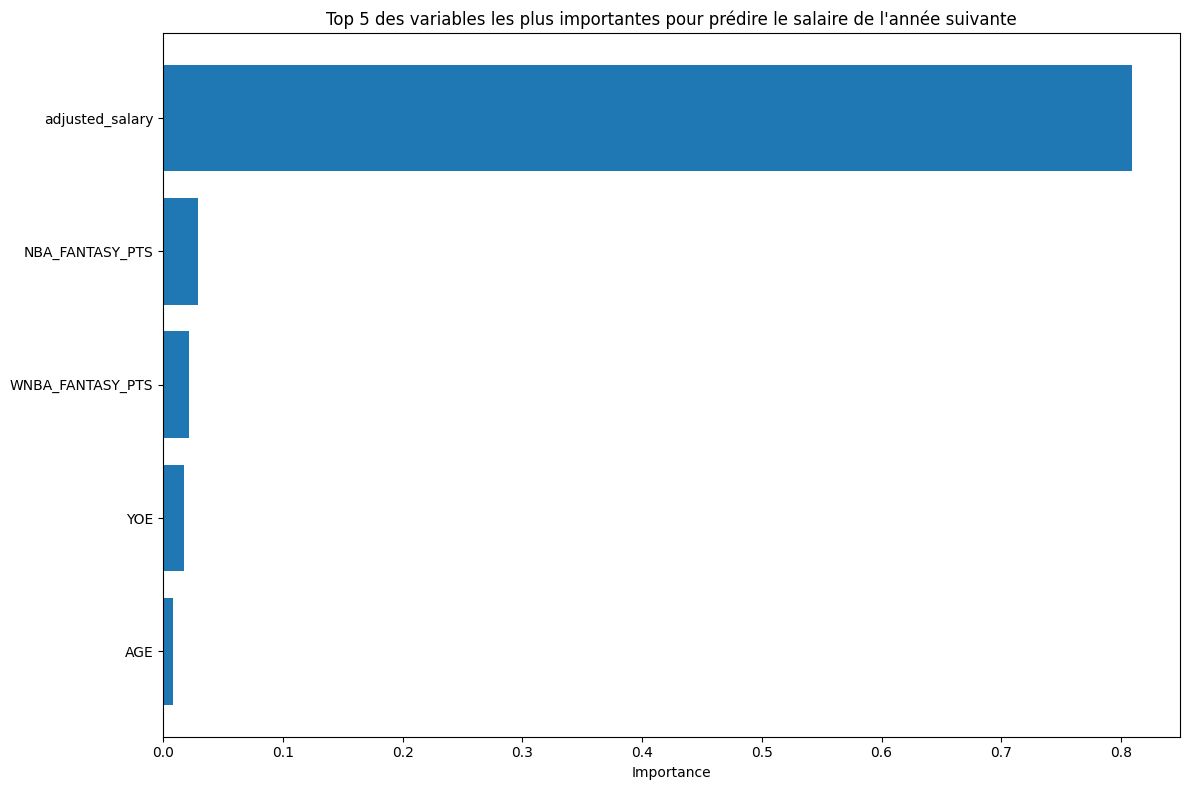

In [11]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n TOP 5 des variables les plus importantes:")
print(feature_importance.head(5).to_string(index=False))

# Visualiser les 5 features les plus importantes
plt.figure(figsize=(12, 8))
top_5 = feature_importance.head(5)
plt.barh(top_5['feature'], top_5['importance'])
plt.xlabel('Importance')
plt.title('Top 5 des variables les plus importantes pour prédire le salaire de l\'année suivante')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

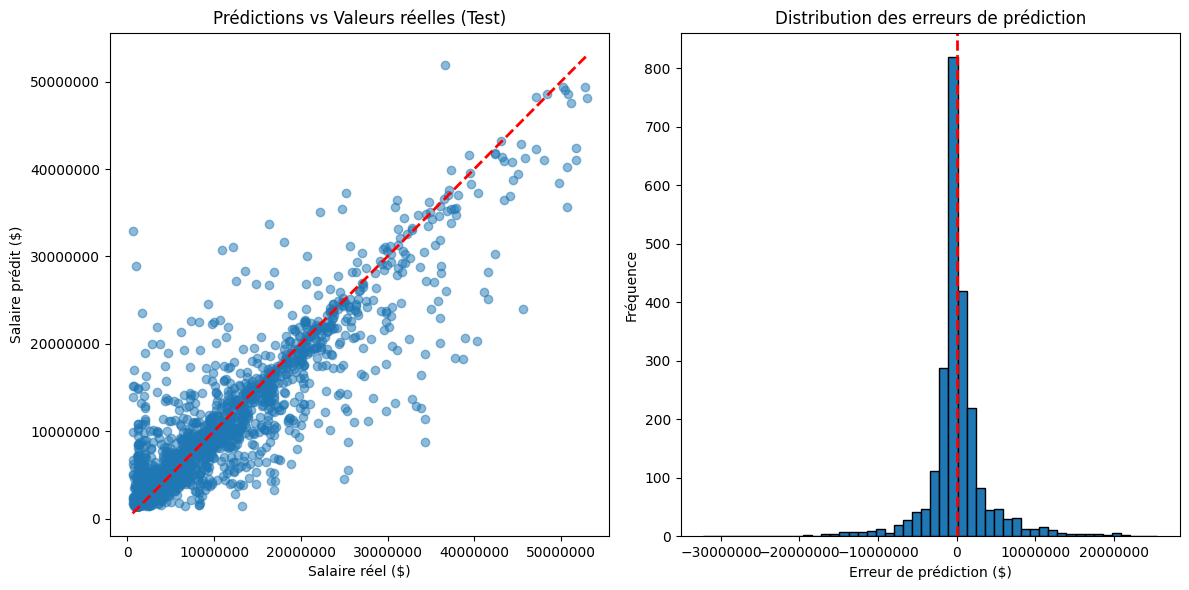


 Statistiques des erreurs:
   Erreur moyenne: $88,151
   Écart-type des erreurs: $4,067,964


In [12]:
# Visualiser les prédictions vs valeurs réelles
plt.figure(figsize=(12, 6))

# Graphique 1: Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Salaire réel ($)')
plt.ylabel('Salaire prédit ($)')
plt.title('Prédictions vs Valeurs réelles (Test)')
plt.ticklabel_format(style='plain', axis='both')

# Graphique 2: Distribution des erreurs
plt.subplot(1, 2, 2)
errors = y_test - y_test_pred
plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel('Erreur de prédiction ($)')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs de prédiction')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

print(f"\n Statistiques des erreurs:")
print(f"   Erreur moyenne: ${errors.mean():,.0f}")
print(f"   Écart-type des erreurs: ${errors.std():,.0f}")

<Figure size 1400x800 with 0 Axes>

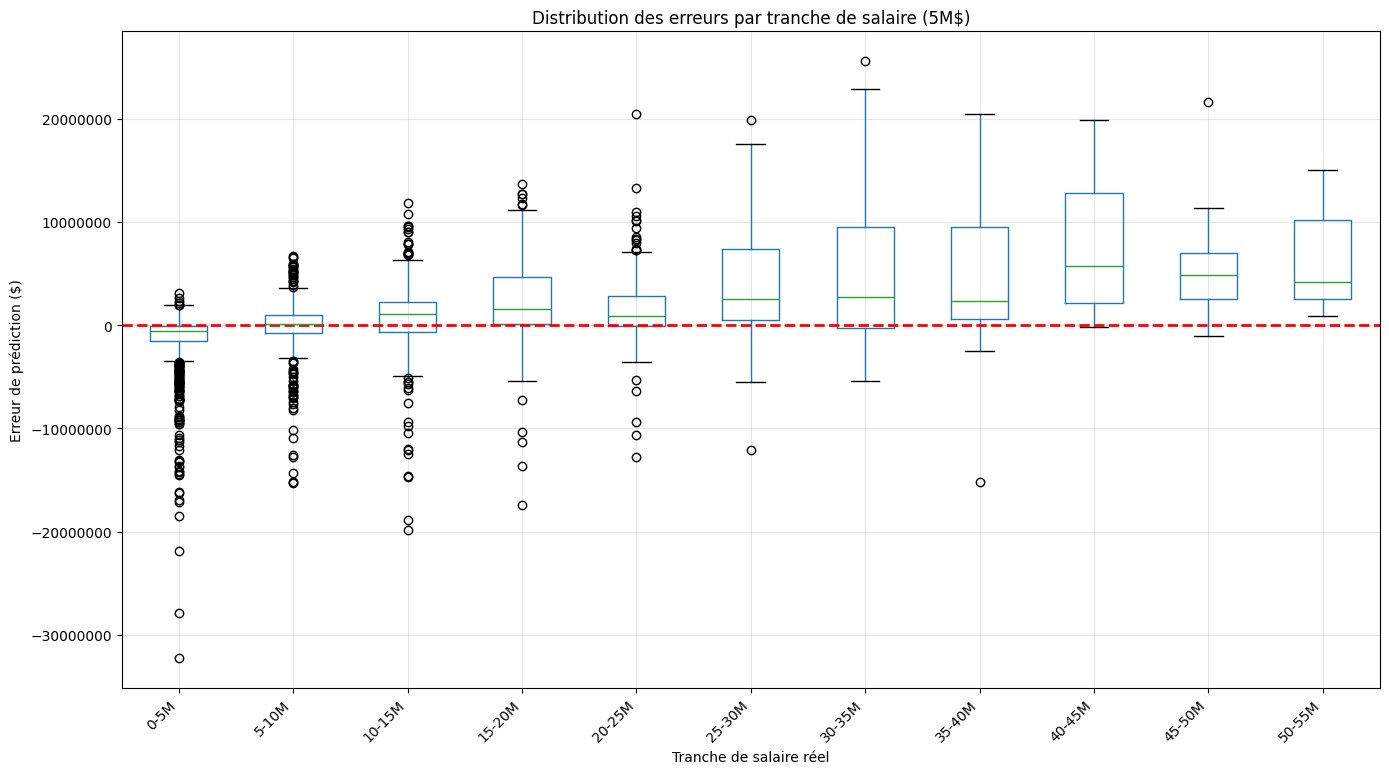


Statistiques des erreurs par tranche de salaire:
              count         mean      median         std
salary_range                                            
0-5M           1046  $-1,389,515   $-526,097  $2,882,771
5-10M           544    $-100,554    $130,846  $2,692,968
10-15M          299     $719,977  $1,031,233  $4,028,608
15-20M          182   $2,215,074  $1,570,790  $4,381,567
20-25M          129   $1,659,740    $922,875  $4,180,659
25-30M           63   $4,220,311  $2,556,306  $6,092,612
30-35M           43   $5,596,086  $2,754,086  $8,071,655
35-40M           31   $4,873,428  $2,366,862  $7,501,151
40-45M           15   $7,276,122  $5,719,885  $6,530,767
45-50M            9   $6,233,744  $4,857,049  $6,861,231
50-55M           10   $6,178,309  $4,160,563  $4,816,516


C:\Users\lunat\AppData\Local\Temp\ipykernel_14176\1064287341.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = error_analysis.groupby('salary_range')['error'].agg([


In [13]:
# Créer des tranches de salaires de 5M pour analyser les erreurs
salary_bins = np.arange(0, y_test.max() + 5000000, 5000000)
salary_labels = [f'{i/1e6:.0f}-{(i+5000000)/1e6:.0f}M' for i in salary_bins[:-1]]

# Assigner chaque salaire à une tranche
y_test_binned = pd.cut(y_test, bins=salary_bins, labels=salary_labels, include_lowest=True)

# Créer un DataFrame avec les erreurs et les tranches
error_analysis = pd.DataFrame({
    'error': errors,
    'salary_range': y_test_binned
})

# Créer le boxplot
plt.figure(figsize=(14, 8))
error_analysis.boxplot(column='error', by='salary_range', figsize=(14, 8))
plt.xlabel('Tranche de salaire réel')
plt.ylabel('Erreur de prédiction ($)')
plt.title('Distribution des erreurs par tranche de salaire (5M$)')
plt.suptitle('')  # Supprimer le titre par défaut de pandas
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# Afficher les statistiques par tranche
print("\nStatistiques des erreurs par tranche de salaire:")
print("="*60)
stats = error_analysis.groupby('salary_range')['error'].agg([
    ('count', 'count'),
    ('mean', lambda x: f'${x.mean():,.0f}'),
    ('median', lambda x: f'${x.median():,.0f}'),
    ('std', lambda x: f'${x.std():,.0f}')
])
print(stats)

In [14]:
# Calculer la baisse de salaire en pourcentage
df_salary_changes = df_clean.copy()
df_salary_changes['salary_change'] = df_salary_changes['next_adjusted_salary'] - df_salary_changes['adjusted_salary']
df_salary_changes['salary_change_pct'] = (df_salary_changes['salary_change'] / df_salary_changes['adjusted_salary']) * 100

# Filtrer les joueurs avec une baisse d'au moins 50%
big_salary_drops = df_salary_changes[df_salary_changes['salary_change_pct'] <= -50].copy()

# Trier par pourcentage de baisse (du plus négatif au moins négatif)
big_salary_drops = big_salary_drops.sort_values('salary_change_pct')

# Récupérer les informations des joueurs depuis le DataFrame original
big_salary_drops_info = df.loc[big_salary_drops.index, ['PLAYER_NAME', 'Year', 'adjusted_salary']].copy()
big_salary_drops_info['next_adjusted_salary'] = big_salary_drops['next_adjusted_salary']
big_salary_drops_info['salary_change'] = big_salary_drops['salary_change']
big_salary_drops_info['salary_change_pct'] = big_salary_drops['salary_change_pct']

print(f"Nombre de joueurs ayant subi une baisse de salaire d'au moins 50%: {len(big_salary_drops_info)}")
print("\n" + "="*100)
print(f"{'Joueur':<25} {'Saison':<10} {'Salaire actuel':>18} {'Salaire suivant':>18} {'Changement':>18} {'% Baisse':>10}")
print("="*100)

for idx, row in big_salary_drops_info.head(20).iterrows():
    print(f"{row['PLAYER_NAME']:<25} {row['Year']:<10} ${row['adjusted_salary']:>16,} ${row['next_adjusted_salary']:>16,.0f} ${row['salary_change']:>16,.0f} {row['salary_change_pct']:>9.1f}%")

print("="*100)
print(f"\nAffichage des 20 plus grosses baisses sur {len(big_salary_drops_info)} au total")

Nombre de joueurs ayant subi une baisse de salaire d'au moins 50%: 544

Joueur                    Saison         Salaire actuel    Salaire suivant         Changement   % Baisse
Ben Simmons               2023-24    $      40,167,012 $         778,501 $     -39,388,511     -98.1%
Chris Webber              2005-06    $      31,747,500 $         655,774 $     -31,091,726     -97.9%
Blake Griffin             2019-20    $      43,751,454 $         971,229 $     -42,780,225     -97.8%
Enes Freedom              2017-18    $      24,581,718 $         628,371 $     -23,953,347     -97.4%
Jeff Teague               2019-20    $      24,130,000 $         638,236 $     -23,491,764     -97.4%
Wesley Matthews           2017-18    $      23,607,112 $         661,442 $     -22,945,670     -97.2%
Danilo Gallinari          2021-22    $      24,570,000 $         701,326 $     -23,868,674     -97.1%
Andre Drummond            2019-20    $      34,408,134 $         993,170 $     -33,414,964     -97.1%
Reggie 